### Linear Variational Approach

We assume that within the nanoplatlet and in the solvent, the exciton experiences a coulomb potential that is screened by the dielectric constant of the nanoplatlet and solvent, respectively.  In the coordinate system of the exciton that has thickness $d$ along the $z$ axis, the columb potential can be written as

$$ V_{npl}(r) = -\frac{e^2}{4\pi \epsilon_{npl}\epsilon_0 r} \; \; {\rm when} \; |r \: {\rm cos}(\theta)| \leq \frac{d}{2} $$

while in the solvent, the potential has the same coulomb form but is screened by the dielectric of the solvent rather than the nanoplatlet:

$$ V_{sol}(r) = -\frac{e^2}{4\pi \epsilon_{sol}\epsilon_0 r} \; \; {\rm when} \; |r \: {\rm cos}(\theta)| > \frac{d}{2}.$$


So we can write the total Hamiltonian as 

\begin{align} 
\hat{H} &= -\frac{\hbar^2}{2\mu} \nabla^2 + V_{npl}(r) + \frac{e^2\left(\epsilon_{sol}-\epsilon_{npl} \right)}{4\pi \epsilon_{sol}\epsilon_{npl}\epsilon_0 r} H(|r \: {\rm cos}(\theta)|-\frac{d}{2}) \\
&= \hat{H}_0 + V'(r,\theta)
\end{align}
where $\mu = \frac{m_e \cdot m_h}{m_e + m_h}$ and is taken to be 0.22 $m_e$ in this work.    

We can expand the ground-state wavefunction as a linear combination of the hydrogenic energy eigenstates
for the bulk npl system:

\begin{equation}
\psi_g(r,\theta,\phi) = \sum_{n,l} c_{n,l} \psi_{n,l,0}(r, \theta, \phi),
\end{equation}

where the coefficients satisfy
$$ {\bf H} {\bf c} = E {\bf c}, $$
with elements of ${\bf H}$ given by
$$ H_{n,l; n',l'} = \langle \psi_{n,l,0} | \hat{H} | \psi_{n',l',0} \rangle \equiv E_{n'} \delta_{n,n'} \delta_{l,l'} +  \langle \psi_{n,l,0} |V' | \psi_{n',l',0} \rangle. $$

Since we know the solution for the bulk npl system, we know
$$ \hat{H}_0 \psi_{n,l,m} = E_n \psi_{n,l,m}, $$
so we just need to be able to compute $ \langle \psi_{n,l,0} |V' | \psi_{n',l',0} \rangle $ numerically (slightly generalized version of what we needed to do in the perturbation theory approach), and then diagonalize the resulting
matrix.  Most likely the matrix need not be that big... perhaps all $n, l$ up to principle quantum number 5 or so... 
We can test for convergence.

In [7]:
### Reworked code some and now just putting everything in this top block
### to compute 1st and 2nd order corrections
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import genlaguerre
from scipy.special import sph_harm
from scipy.interpolate import UnivariateSpline
from numpy import linalg as LA
from scipy.sparse.linalg import eigs
import math

''' Define various constants here! '''
###  !!!! npl thickness in nanometers, see page 2 of manuscript
#### 2 mL d_nm = 0.7
#### 5 mL = 1.9 nm
d_nm = 1.7

# conversion from nm to atomic units
nm_to_au = 18.89725988579

# d in atomic units
d = d_nm * nm_to_au

# electron-hole reduced mass in atomic units
mu = 0.22
# relative permittivity of NPL... see page 10 of the manuscript
eps_m = 10
# relative permittivity of medium.... see page 10 of the manuscript
eps_sol = 2
# k = 4*pi*epsilon_0 in atomic units
k = 1
# hbar in atomic units
hbar = 1
# electron charge in atomic units
ec = 1

''' It is now unclear to me if we can hard-code the bohr radius and
    still assume that psi_nlm(r,theta,phi; a0) is an eigenfunction of H_0
    so I'm reverting to computing a0 from \mu and \epsilon for now 
# bohr radius in atomic units using Azmain's value
#a0b = 0.82*18.89725988579 

# zeroth order ground state approach B - using Azmain's value of a0, which is a0b
#E_z = -ec**2/(8*np.pi*eps_m * a0b) '''

# a0 = 4*pi*epsilon_0 * epsilon_m * hbar^2 / (mu * e^2)
# in atomic units, everything is 1 except epsilon_m / mu 
a0b = eps_m / mu

# take the two different approaches for computing the ground-state energy
# (1) E_n = -mu * e^4/(n^2 * 2 * (4 pi epsilon_0)^2 epsilon_m^2 \hbar^2)
#     where in atomic units, everything is 1 except
#     E_n = -mu / (n^2 * 2 * epsilon_m^2 )
# 
# (2) E_n = -e^2 / (n^2 * 2 * (4 * pi * epsilon_0) * epsilon_m * a0)
#     where in atomic units, everything is 1 except
#     E_n = -1/(n^2 * 2 * epsilon_m * a0)

def En_using_mu(n, redmass, epsilon_m):
    return -redmass / (n**2 * 2 * epsilon_m**2)

def En_using_a(n, a0, epsilon_m):
    return -1/(n**2 * 2 * epsilon_m * a0)

# get Eg using approach (1)
E1_from_mu = En_using_mu(1, mu, eps_m)
# get Eg using approach (2)
E1_from_a0 = En_using_a(1, a0b, eps_m)

print(" bohr radius in atomic units:",a0b)
print(" bohr radius in nm:",a0b/nm_to_au)
print(" E1 from mu:", E1_from_mu * 27.211 * 1000)
print(" E1 from a0:", E1_from_a0 * 27.211 * 1000)
print(" Difference:",(E1_from_mu-E1_from_a0)*27.211*1000)
print(" Nanoplatlet thickness in nanometers", d_nm)
print(" Nanoplatlet thickness in atomic units", d)



 bohr radius in atomic units: 45.45454545454545
 bohr radius in nm: 2.405351131818084
 E1 from mu: -29.9321
 E1 from a0: -29.9321
 Difference: 0.0
 Nanoplatlet thickness in nanometers 1.7
 Nanoplatlet thickness in atomic units 32.125341805843


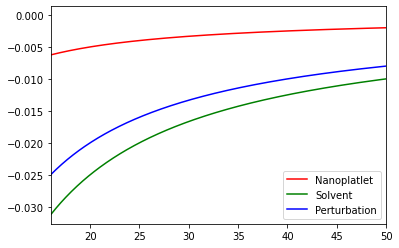

In [8]:
''' Set up grids for the potential and the wavefunction '''
# radius grid in atomic units
r_perturb = np.linspace(d/2, 500, 5000)
r_array = np.linspace(1e-9, 500, 5000)
# theta grid
th = np.linspace(0, np.pi, 100)
# phi grid
phi = np.linspace(0, 2*np.pi, 100)

# perturbing potential
V_perturb = ec**2 * (eps_sol - eps_m)/(k*eps_sol*eps_m*r_perturb)
# potential in nanoplatlet
Vnp = -ec**2/(k * eps_m * r_perturb)
# potential in solvent 
Vsol = -ec**2/(k*eps_sol * r_perturb)


plt.plot(r_perturb, Vnp, 'red', label="Nanoplatlet")
plt.plot(r_perturb, Vsol, "green", label="Solvent")
plt.plot(r_perturb, V_perturb, "blue", label="Perturbation")
plt.xlim(d/2, 50)
plt.legend()
plt.show()

In [9]:
# To get perturbative corrections, we need to be able to generate
# 0th-order eigenfunctions and eigenenergies!  

# 0th order eigenfunction radial part
def R(n,l,r, a0):
    '''Returns the radial wavefunction for each value of r where n is the principle quantum number 
         and l is the angular momentum quantum number.'''
    norm = np.sqrt( (2/(n*a0))**3 * math.factorial(n - l - 1)/(math.factorial(n+l) * 2 * n))
    t1 = np.exp(-r/(n*a0))
    t2 = (2*r/(n*a0))**l
    #Generates an associated laguerre polynomial as a scipy.special.orthogonal.orthopoly1
    Lag = genlaguerre(n-l-1, 2*l+1)
    t3 = Lag(2*r/(n*a0))
    return norm * t1 * t2 * t3

def test_norm(n, l, r, theta, a0):
    # bra state
    R_bra = R(n, l, r, a0)
    Y_bra = sph_harm(0, l, 0, theta)
    
    R_integrand = np.conj(R_bra) * R_bra * r * r
    Y_integrand = np.real(np.conj(Y_bra) * Y_bra * np.sin(theta))
    
    R_integral = np.trapz(R_integrand, r)
    Y_integral = np.trapz(Y_integrand, theta)
    return 2*np.pi*R_integral*Y_integral

# return matrix element of Hamiltonian for linear variational method
# there are two terms contributing to <\psi_n,l,m | H | \psi_n',l',m'>:
# = <\psi_n,l,m | H_0 | \psi_n',l',m'> + <\psi_n,l,m | Vp | \psi_n',l',m'>
# = E_n' * delta_{n,n'} * delta_{l,l'} * delta_{m, m'} + <\psi_n,l,m | Vp | \psi_n',l',m'>
def H_ij(bra_n, bra_l, ket_n, ket_l, Vp, r, theta, a0, npl_thickness, epsilon_m):
    ''' We can factor the integral over phi from the integral over theta and r...
        plus integral over theta and r just becomes integral over r weighted by
        the slices of theta that extend outslide the platlet since we cannot couple
        m != 1 states to the psi_100 state through this potential, so the
        0th-order eigenfunctions are all constants along \theta!!!! '''
    
    Ej = 0
    # Get easy part if bra and ket are the same!
    if (bra_n==ket_n and bra_l == ket_l):
        #Ej = En_using_mu(ket_n, mu, eps_m)
        Ej = En_using_a(ket_n, a0, epsilon_m)
    
    ### get 0th-order ket terms
    R_bra = R(bra_n, bra_l, r, a0)
    Y_bra = sph_harm(0, bra_l, 0, theta)
    
    ### get 0th-order bra terms
    R_ket = R(ket_n, ket_l, r, a0)
    Y_ket = sph_harm(0, ket_l, 0, theta)
    
    #plt.plot(theta, np.conj(Y_bra)*Y_ket * np.sin(theta) , 'green')
    #plt.show()
    
    ### compute integrand over theta
    Y_integrand = np.real(np.conj(Y_bra) * Y_ket * np.sin(theta))
    ### fit spline to integrand over theta
    Y_spline = UnivariateSpline(theta, Y_integrand)
    fac_phi = 2*np.pi
    
    dE = 0
    dr = r[1]-r[0]
    for i in range(0,len(r)):
        th_max = np.arccos(npl_thickness/(2*r[i]))
        fac_theta_up = Y_spline.integral(0, th_max)
        fac_theta_down = Y_spline.integral(np.pi-th_max, np.pi)
        fac_theta = fac_theta_up + fac_theta_down
        dE += R_bra[i] * R_ket[i] * r[i]**2 * Vp[i] * dr * fac_theta
        
    return Ej + fac_phi * dE


In [10]:
# Build the possible quantum numbers n and l into a list (m is always zero!)
# figure out the size of the Hamiltonian matrix for all psi_n,l,0 basis states up to n_max:
qn = []
n_max =9
for n in range(n_max):
    for l in range(0, n):
        qn.append((n, l))
        
print(qn)
print(len(qn))
dim = len(qn)
Hmat = np.zeros((dim, dim))

[(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]
36


In [11]:
# Form matrix elements of shifted CIS Hamiltonian
for i, bra_qn in enumerate(qn):
    bn, bl = bra_qn
    for j, ket_qn in enumerate(qn):
        kn, kl = ket_qn
        Hmat[i, j] = H_ij(bn, bl, kn, kl, V_perturb, r_perturb, th, a0b, d, eps_m)

            
### If you want to see the Hamiltonian matrix, uncomment
#print(Hmat)

In [12]:
### Diagonalize Hmat and print eigenvalues!
vals, vecs = LA.eigh(Hmat)
print("  Variational Binding Energy in meV is:",-1*vals[0]*27.211*1000)


  Variational Binding Energy in meV is: 152.12597873569277


 Note <r> for R_10^{(0)} should be 3/2 * a0 or 68.18181818181819 atomic units
 <r> for 0th order: 68.18178442935354
 <r> for variational 62.75053587929132


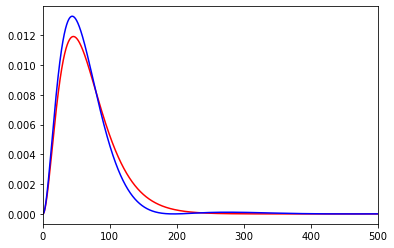

In [8]:
R_zero_order = R(1, 0, r_array, a0b)
R_variational = np.zeros_like(R_zero_order)

for i, bra_qn in enumerate(qn):
    bn, bl = bra_qn
    R_variational += vecs[i,0] * R(bn, bl, r_array, a0b)

Norm_z0 = np.trapz(R_zero_order**2 * r_array**2, r_array)
Norm_var = np.trapz(R_variational**2 * r_array**2, r_array)

r_num_z0 = np.trapz(R_zero_order**2 * r_array**3, r_array)
r_num_var = np.trapz(R_variational**2 * r_array**3, r_array)

r_expt_z0 = r_num_z0 / Norm_z0

r_expt_var = r_num_var / Norm_var

print(" Note <r> for R_10^{(0)} should be 3/2 * a0 or", a0b*3/2,"atomic units")
print(" <r> for 0th order:", r_expt_z0)
print(" <r> for variational", r_expt_var)


#R_zero_order *= (1/Norm_z0)
#R_first_order *= (1/Norm_f0)
plt.plot(r_array, R_zero_order**2*r_array**2, 'red')
plt.plot(r_array, R_variational**2*r_array**2, 'blue')
plt.xlim(0, 500)
plt.show()